In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [4]:
data = pd.read_csv('../../Data/20%_Loans_12_feat_scaled.csv')
data.head(5)

,loan_amnt,int_rate,installment,annual_inc,dti,fico_range_low,pub_rec,term,grade,emp_length,Not Verified,Source Verified,Verified,ANY,MORTGAGE,NONE,OTHER,OWN,RENT,loan_status_bin
0,-0.813096,-0.398686,-0.934226,0.562180,0.284043,0.654268,-0.379653,0.731341,0.845577,-0.664012,-0.379497,1.303870,-1.007532,-0.017317,1.086550,-0.007383,-0.007383,-0.357405,-0.864539,1.0
1,0.638440,0.261028,0.470223,0.029274,-0.010299,-1.040687,-0.379653,0.731341,0.845577,-0.409357,2.635065,-0.766948,-1.007532,-0.017317,1.086550,-0.007383,-0.007383,-0.357405,-0.864539,0.0
2,-0.241914,-0.148068,-0.394106,-0.513897,0.900017,3.559904,-0.379653,0.731341,0.845577,1.118570,2.635065,-0.766948,-1.007532,-0.017317,-0.920345,-0.007383,-0.007383,2.797949,-0.864539,1.0
3,0.517915,-1.117370,0.188206,0.662975,-0.036939,-1.040687,-0.379653,0.731341,-0.408699,-0.918667,2.635065,-0.766948,-1.007532,-0.017317,-0.920345,-0.007383,-0.007383,2.797949,-0.864539,0.0
4,1.765084,-1.117370,1.276645,0.844032,0.954597,0.896404,-0.379653,0.731341,-0.408699,0.609261,-0.379497,1.303870,-1.007532,-0.017317,1.086550,-0.007383,-0.007383,-0.357405,-0.864539,1.0


In [5]:
data.shape

(110074, 20)

In [6]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    65325
0.0    44749
Name: loan_status_bin, dtype: int64

In [7]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(110074, 19)

In [8]:
y = data['loan_status_bin']

In [9]:
lr1 = LogisticRegression()

In [10]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [11]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.6119464  0.61417216 0.6096298  0.60640472 0.61192877]
0.61081637000929


In [12]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[10184, 34565],
       [ 8274, 57051]])

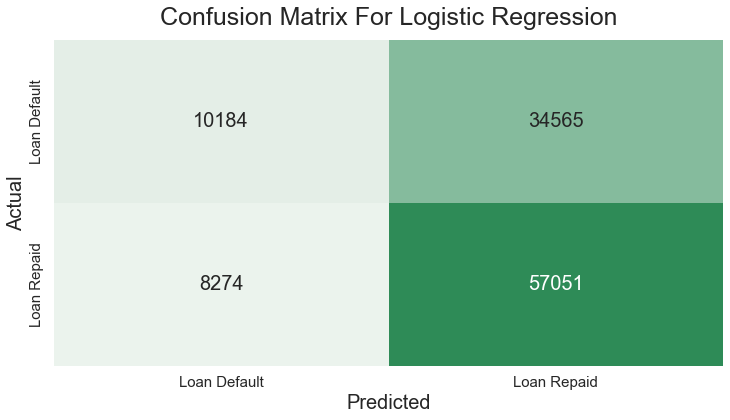

In [13]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [14]:
accuracy_score(y, y_pred)

0.6108163599033377

In [15]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

57051
34565
8274
10184
0.6108163599033377


In [20]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    65325
0.0    44749
Name: loan_status_bin, dtype: int64

0.5934643966785981


In [21]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.622718739084876

In [24]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [25]:
y_pred_prob

array([[0.36216196, 0.63783804],
       [0.40053507, 0.59946493],
       [0.36612899, 0.63387101],
       ...,
       [0.30416421, 0.69583579],
       [0.34883961, 0.65116039],
       [0.30814722, 0.69185278]])

In [27]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[44532,   217],
       [64332,   993]])

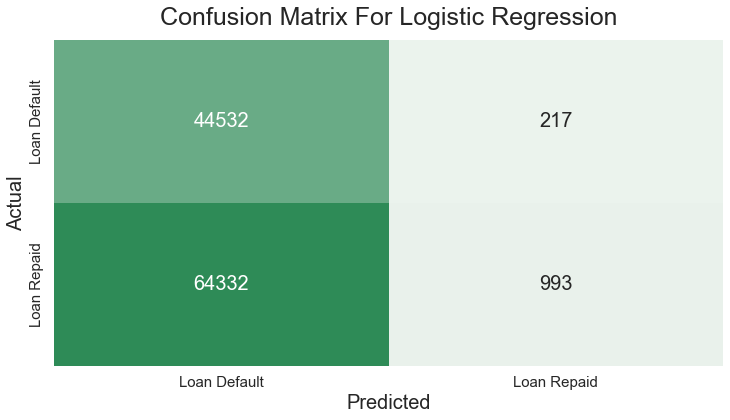

In [29]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [30]:
accuracy_score(y, y_pred_success)

0.41358540618129624

In [31]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

993
217
64332
44532
0.41358540618129624


In [32]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8206611570247934

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 